In [0]:
trocar newfaces por noisyfaces

### Imports

In [1]:
from sklearn.datasets import fetch_lfw_people
from matplotlib import pyplot as plt
from matplotlib.pyplot import imread
import numpy as np
import seaborn as sns
import scipy

import keras
from keras.layers import Input, Dense, Conv2D, MaxPooling2D, UpSampling2D, Dropout
from keras.models import Model
from sklearn.model_selection import train_test_split
from keras import metrics # https://keras.io/metrics/ - ver a parte de custom metrics
from keras.callbacks import History 
from keras.utils.vis_utils import plot_model

import tensorflow as tf

Using TensorFlow backend.


### Funções minhas

In [2]:
# Adicionando ruído às imagens
def add_noise(sigma, bw_img):
    """Adiciona ruído a uma imagem em escala de cinza com valores entre 0 e 1"""
    sh = bw_img.shape
    noise = np.random.normal(0, sigma, sh)
    newgray = bw_img + noise
    #np.clip(newgray, 0, 1) # quando faço isso ela deixa de ser normal!!!
    # vou parar de clipar.
    return newgray


def plota_pra_mim_pfv(pred, numero):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(faces[numero].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(newfaces[numero].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(pred[numero].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

def plota_comparacao(idx, original, noisy, predicted):
    figures, axes = plt.subplots(1, 3)
    axes[0].imshow(original[idx].reshape(60, 44), cmap = 'gray')
    axes[0].set_title('Original image')
    axes[1].imshow(noisy[idx].reshape(60, 44), cmap = 'gray')
    axes[1].set_title('Input (noisy image)')
    axes[2].imshow(predicted[idx].reshape(60, 44), cmap = 'gray')
    axes[2].set_title('Reconstructed')

### Base de dados

In [3]:
db = fetch_lfw_people()

In [4]:
faces = db['data']
total_imagens = len(faces)
faces_matrix = np.empty((total_imagens, 60, 44))

for i in range(total_imagens):
    faces_matrix[i] = faces[i].reshape(62, 47)[1:61, 1:45]

# Normalizando imagens
faces_matrix = faces_matrix/np.amax(faces_matrix)

# Adicionando ruído
del faces
faces = faces_matrix
newfaces = add_noise(0.05, faces)

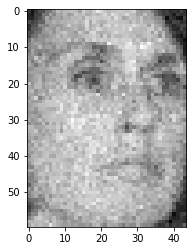

In [5]:
plt.imshow(newfaces[5], cmap = 'gray')

## Separando em treino e teste

In [12]:
# Separando em treino e teste
# train_test = train_test_split(faces_matrix, test_size = 0.2)
treino, teste, newtreino, newteste = train_test_split(faces_matrix, newfaces, test_size = 0.2, random_state = 1)

In [13]:
len(newtreino)

10586

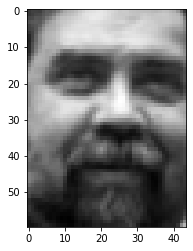

In [14]:
plt.imshow(treino[5], cmap = 'gray')

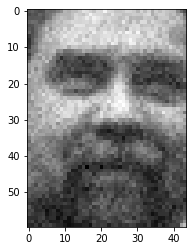

In [15]:
plt.imshow(newtreino[5], cmap = 'gray')

In [16]:
newtreino = newtreino.reshape(-1, 60, 44, 1)
treino = treino.reshape(-1, 60, 44, 1)

newteste = newteste.reshape(-1, 60, 44, 1)
teste = teste.reshape(-1, 60, 44, 1)

### Escolhendo métricas que serão monitoradas

In [18]:
# Funções custo e métricas podem ser utilizadas como métricas
metricas = [ ###### LOSSES:
            'mean_squared_error', 'mean_absolute_error',
            #'cosine_proximity',
            #'mean_absolute_percentage_error', 'mean_squared_logarithmic_error',
            #'hinge', 'squared_hinge', 'logcosh', 
            'binary_crossentropy', 
            #'huber_loss', 
            #'kullback_leibler_divergence',
            #'poisson',
             ###### METRICS:
            'accuracy' 
            #, 'binary_accuracy'
            ] # as outras metrics são categóricas.

## Funcao custo customizada: SSIM

In [19]:
def ssim_loss(y_true, y_pred):
  return -tf.reduce_mean(tf.image.ssim(y_true, y_pred, 1.0))

# Para testes rápidos (1 rede só):

In [47]:
# Para testes rápidos (1 rede só):
autoencoders = [None]
historias = [None]

cont = 0

def make_autoencoder():
  # encoding
  inputs = Input(shape=(60, 44, 1)) 
  x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
  x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
  x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
  encoded = MaxPooling2D(padding = 'same')(x)

  # decoding
  x = UpSampling2D(size = (2, 2))(x)
  decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

  # autoencoder compilation
  autoencoder = Model(inputs, decoded)
  autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = metricas)
  return autoencoder
autoencoders[cont] = make_autoencoder()
historias[cont] = History()

autoencoders[cont].fit(newtreino, treino, epochs=200, batch_size=128, callbacks=[historias[cont]], validation_split = 0.1)

Train on 9527 samples, validate on 1059 samples
Epoch 1/200
9527/9527 [==============================] - 15s 2ms/step - loss: 0.0188 - mean_squared_error: 0.0188 - mean_absolute_error: 0.1022 - binary_crossentropy: 0.6648 - accuracy: 4.7155e-05 - val_loss: 0.0048 - val_mean_squared_error: 0.0048 - val_mean_absolute_error: 0.0470 - val_binary_crossentropy: 0.6351 - val_accuracy: 5.1864e-05
Epoch 2/200
9527/9527 [==============================] - 14s 1ms/step - loss: 0.0034 - mean_squared_error: 0.0034 - mean_absolute_error: 0.0400 - binary_crossentropy: 0.6317 - accuracy: 4.8904e-05 - val_loss: 0.0026 - val_mean_squared_error: 0.0026 - val_mean_absolute_error: 0.0351 - val_binary_crossentropy: 0.6301 - val_accuracy: 5.1864e-05
Epoch 3/200
9527/9527 [==============================] - 15s 2ms/step - loss: 0.0022 - mean_squared_error: 0.0022 - mean_absolute_error: 0.0326 - binary_crossentropy: 0.6287 - accuracy: 4.8904e-05 - val_loss: 0.0018 - val_mean_squared_error: 0.0018 - val_mean_abso

9527/9527 [==============================] - 24s 3ms/step - loss: 8.4938e-04 - mean_squared_error: 8.4938e-04 - mean_absolute_error: 0.0222 - binary_crossentropy: 0.6252 - accuracy: 4.8904e-05 - val_loss: 8.4558e-04 - val_mean_squared_error: 8.4558e-04 - val_mean_absolute_error: 0.0222 - val_binary_crossentropy: 0.6254 - val_accuracy: 5.1864e-05
Epoch 25/200
9527/9527 [==============================] - 25s 3ms/step - loss: 8.4382e-04 - mean_squared_error: 8.4382e-04 - mean_absolute_error: 0.0221 - binary_crossentropy: 0.6252 - accuracy: 4.8904e-05 - val_loss: 8.3526e-04 - val_mean_squared_error: 8.3526e-04 - val_mean_absolute_error: 0.0220 - val_binary_crossentropy: 0.6254 - val_accuracy: 5.1864e-05
Epoch 26/200
9527/9527 [==============================] - 25s 3ms/step - loss: 8.3898e-04 - mean_squared_error: 8.3898e-04 - mean_absolute_error: 0.0220 - binary_crossentropy: 0.6252 - accuracy: 4.8904e-05 - val_loss: 8.4598e-04 - val_mean_squared_error: 8.4598e-04 - val_mean_absolute_error

Epoch 47/200
9527/9527 [==============================] - 24s 3ms/step - loss: 7.8000e-04 - mean_squared_error: 7.8000e-04 - mean_absolute_error: 0.0214 - binary_crossentropy: 0.6250 - accuracy: 4.8904e-05 - val_loss: 7.7719e-04 - val_mean_squared_error: 7.7719e-04 - val_mean_absolute_error: 0.0214 - val_binary_crossentropy: 0.6252 - val_accuracy: 5.1864e-05
Epoch 48/200
9527/9527 [==============================] - 25s 3ms/step - loss: 7.7882e-04 - mean_squared_error: 7.7882e-04 - mean_absolute_error: 0.0214 - binary_crossentropy: 0.6250 - accuracy: 4.8904e-05 - val_loss: 7.7382e-04 - val_mean_squared_error: 7.7382e-04 - val_mean_absolute_error: 0.0213 - val_binary_crossentropy: 0.6252 - val_accuracy: 5.1864e-05
Epoch 49/200
9527/9527 [==============================] - 24s 3ms/step - loss: 7.7568e-04 - mean_squared_error: 7.7568e-04 - mean_absolute_error: 0.0213 - binary_crossentropy: 0.6250 - accuracy: 4.8904e-05 - val_loss: 7.9042e-04 - val_mean_squared_error: 7.9042e-04 - val_mean_a

Epoch 70/200
9527/9527 [==============================] - 24s 3ms/step - loss: 7.3388e-04 - mean_squared_error: 7.3388e-04 - mean_absolute_error: 0.0207 - binary_crossentropy: 0.6249 - accuracy: 4.8904e-05 - val_loss: 7.3248e-04 - val_mean_squared_error: 7.3248e-04 - val_mean_absolute_error: 0.0207 - val_binary_crossentropy: 0.6251 - val_accuracy: 5.1864e-05
Epoch 71/200
9527/9527 [==============================] - 25s 3ms/step - loss: 7.3585e-04 - mean_squared_error: 7.3585e-04 - mean_absolute_error: 0.0207 - binary_crossentropy: 0.6249 - accuracy: 4.8904e-05 - val_loss: 7.3820e-04 - val_mean_squared_error: 7.3820e-04 - val_mean_absolute_error: 0.0208 - val_binary_crossentropy: 0.6251 - val_accuracy: 5.1864e-05
Epoch 72/200
9527/9527 [==============================] - 25s 3ms/step - loss: 7.3408e-04 - mean_squared_error: 7.3408e-04 - mean_absolute_error: 0.0207 - binary_crossentropy: 0.6249 - accuracy: 4.8904e-05 - val_loss: 7.2511e-04 - val_mean_squared_error: 7.2511e-04 - val_mean_a

Epoch 93/200
9527/9527 [==============================] - 26s 3ms/step - loss: 7.1644e-04 - mean_squared_error: 7.1644e-04 - mean_absolute_error: 0.0205 - binary_crossentropy: 0.6248 - accuracy: 4.8904e-05 - val_loss: 7.1292e-04 - val_mean_squared_error: 7.1292e-04 - val_mean_absolute_error: 0.0205 - val_binary_crossentropy: 0.6250 - val_accuracy: 5.1864e-05
Epoch 94/200
9527/9527 [==============================] - 25s 3ms/step - loss: 7.1612e-04 - mean_squared_error: 7.1612e-04 - mean_absolute_error: 0.0205 - binary_crossentropy: 0.6248 - accuracy: 4.8904e-05 - val_loss: 7.1370e-04 - val_mean_squared_error: 7.1370e-04 - val_mean_absolute_error: 0.0205 - val_binary_crossentropy: 0.6250 - val_accuracy: 5.1864e-05
Epoch 95/200
9527/9527 [==============================] - 25s 3ms/step - loss: 7.1674e-04 - mean_squared_error: 7.1674e-04 - mean_absolute_error: 0.0205 - binary_crossentropy: 0.6248 - accuracy: 4.8904e-05 - val_loss: 7.1490e-04 - val_mean_squared_error: 7.1490e-04 - val_mean_a

Epoch 116/200
9527/9527 [==============================] - 25s 3ms/step - loss: 7.0224e-04 - mean_squared_error: 7.0224e-04 - mean_absolute_error: 0.0203 - binary_crossentropy: 0.6248 - accuracy: 4.8904e-05 - val_loss: 6.9568e-04 - val_mean_squared_error: 6.9568e-04 - val_mean_absolute_error: 0.0202 - val_binary_crossentropy: 0.6250 - val_accuracy: 5.1864e-05
Epoch 117/200
9527/9527 [==============================] - 24s 3ms/step - loss: 6.9892e-04 - mean_squared_error: 6.9892e-04 - mean_absolute_error: 0.0202 - binary_crossentropy: 0.6248 - accuracy: 4.8904e-05 - val_loss: 6.9372e-04 - val_mean_squared_error: 6.9372e-04 - val_mean_absolute_error: 0.0202 - val_binary_crossentropy: 0.6250 - val_accuracy: 5.1864e-05
Epoch 118/200
9527/9527 [==============================] - 25s 3ms/step - loss: 6.9763e-04 - mean_squared_error: 6.9763e-04 - mean_absolute_error: 0.0202 - binary_crossentropy: 0.6248 - accuracy: 4.8904e-05 - val_loss: 6.9469e-04 - val_mean_squared_error: 6.9469e-04 - val_mea

Epoch 139/200
9527/9527 [==============================] - 25s 3ms/step - loss: 6.8813e-04 - mean_squared_error: 6.8813e-04 - mean_absolute_error: 0.0201 - binary_crossentropy: 0.6247 - accuracy: 4.8904e-05 - val_loss: 6.8288e-04 - val_mean_squared_error: 6.8288e-04 - val_mean_absolute_error: 0.0200 - val_binary_crossentropy: 0.6250 - val_accuracy: 5.1864e-05
Epoch 140/200
9527/9527 [==============================] - 25s 3ms/step - loss: 6.9275e-04 - mean_squared_error: 6.9275e-04 - mean_absolute_error: 0.0202 - binary_crossentropy: 0.6248 - accuracy: 4.8904e-05 - val_loss: 6.8129e-04 - val_mean_squared_error: 6.8129e-04 - val_mean_absolute_error: 0.0200 - val_binary_crossentropy: 0.6249 - val_accuracy: 5.1864e-05
Epoch 141/200
9527/9527 [==============================] - 25s 3ms/step - loss: 6.9424e-04 - mean_squared_error: 6.9424e-04 - mean_absolute_error: 0.0202 - binary_crossentropy: 0.6248 - accuracy: 4.8904e-05 - val_loss: 6.8093e-04 - val_mean_squared_error: 6.8093e-04 - val_mea

Epoch 162/200
9527/9527 [==============================] - 24s 3ms/step - loss: 6.8502e-04 - mean_squared_error: 6.8502e-04 - mean_absolute_error: 0.0201 - binary_crossentropy: 0.6247 - accuracy: 4.8904e-05 - val_loss: 6.7275e-04 - val_mean_squared_error: 6.7275e-04 - val_mean_absolute_error: 0.0199 - val_binary_crossentropy: 0.6249 - val_accuracy: 5.1864e-05
Epoch 163/200
9527/9527 [==============================] - 24s 3ms/step - loss: 6.8251e-04 - mean_squared_error: 6.8251e-04 - mean_absolute_error: 0.0200 - binary_crossentropy: 0.6247 - accuracy: 4.8904e-05 - val_loss: 6.7383e-04 - val_mean_squared_error: 6.7383e-04 - val_mean_absolute_error: 0.0199 - val_binary_crossentropy: 0.6249 - val_accuracy: 5.1864e-05
Epoch 164/200
9527/9527 [==============================] - 24s 3ms/step - loss: 6.8315e-04 - mean_squared_error: 6.8315e-04 - mean_absolute_error: 0.0200 - binary_crossentropy: 0.6247 - accuracy: 4.8904e-05 - val_loss: 6.7218e-04 - val_mean_squared_error: 6.7218e-04 - val_mea

Epoch 185/200
9527/9527 [==============================] - 24s 3ms/step - loss: 6.7495e-04 - mean_squared_error: 6.7495e-04 - mean_absolute_error: 0.0199 - binary_crossentropy: 0.6247 - accuracy: 4.8904e-05 - val_loss: 6.6736e-04 - val_mean_squared_error: 6.6736e-04 - val_mean_absolute_error: 0.0198 - val_binary_crossentropy: 0.6249 - val_accuracy: 5.1864e-05
Epoch 186/200
9527/9527 [==============================] - 25s 3ms/step - loss: 6.7132e-04 - mean_squared_error: 6.7132e-04 - mean_absolute_error: 0.0199 - binary_crossentropy: 0.6247 - accuracy: 4.8904e-05 - val_loss: 6.8423e-04 - val_mean_squared_error: 6.8423e-04 - val_mean_absolute_error: 0.0201 - val_binary_crossentropy: 0.6249 - val_accuracy: 5.1864e-05
Epoch 187/200
9527/9527 [==============================] - 25s 3ms/step - loss: 6.7668e-04 - mean_squared_error: 6.7668e-04 - mean_absolute_error: 0.0200 - binary_crossentropy: 0.6247 - accuracy: 4.8904e-05 - val_loss: 6.8142e-04 - val_mean_squared_error: 6.8142e-04 - val_mea

In [48]:
autoencoders[0].save('200iter_MSE')

In [49]:
import pickle
pickle.dump(historias[0], open( "save_historias_200iter_mse", "wb" ) )

In [50]:
predicoes_treino = autoencoders[cont].predict(newtreino) # in sample
predicoes_teste = autoencoders[cont].predict(newteste) # out of sample

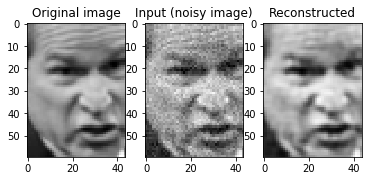

In [51]:
plota_comparacao(25, teste, newteste, predicoes_teste) # previsao out of sample

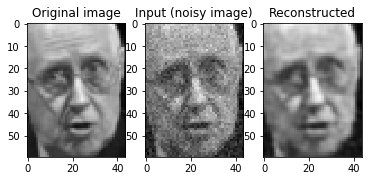

In [52]:
plota_comparacao(15, treino, newtreino, predicoes_treino) # previsao in sample

Text(0.5, 1.0, 'loss')

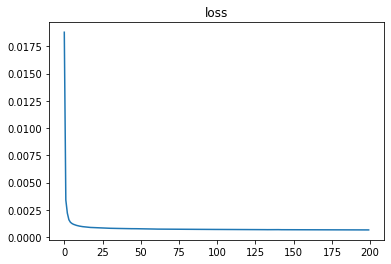

In [53]:
cont = 0
sns.lineplot(range(len(historias[cont].history['loss'])), historias[cont].history['loss']).set_title('loss')

Text(0.5, 1.0, 'validation loss')

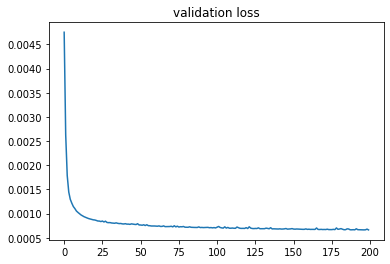

In [54]:
sns.lineplot(range(len(historias[cont].history['val_loss'])), historias[cont].history['val_loss']).set_title('validation loss')

Text(0.5, 1.0, 'mean_squared_error')

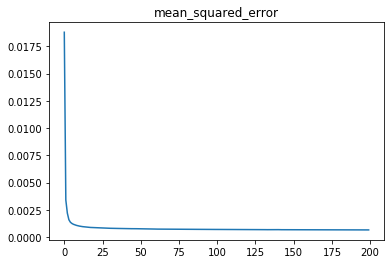

In [55]:
sns.lineplot(range(len(historias[cont].history['mean_squared_error'])), historias[cont].history['mean_squared_error']).set_title('mean_squared_error')

Text(0.5, 1.0, 'val_mean_squared_error')

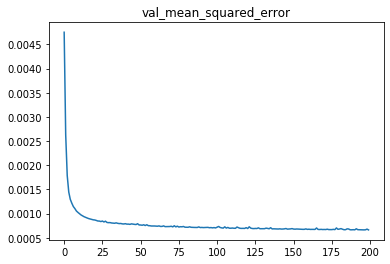

In [56]:
sns.lineplot(range(len(historias[cont].history['val_mean_squared_error'])), historias[cont].history['val_mean_squared_error']).set_title('val_mean_squared_error')

Text(0.5, 1.0, 'accuracy')

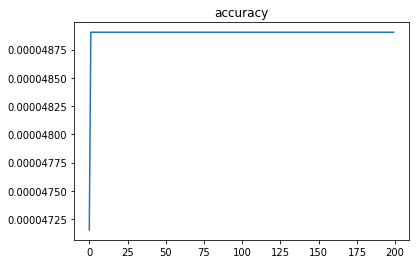

In [57]:
sns.lineplot(range(len(historias[cont].history['accuracy'])), historias[cont].history['accuracy']).set_title('accuracy')

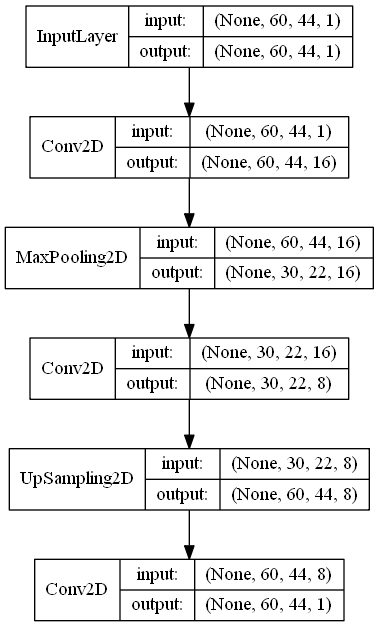

In [42]:
plot_model(autoencoders[cont], show_shapes=True, show_layer_names=False)

## Variando funcao custo com uma arquitetura fixada

In [0]:
custos = [ 'mean_squared_error', 'mean_absolute_error', 'cosine_proximity',
            'mean_absolute_percentage_error', 'mean_squared_logarithmic_error',
            'hinge', 'squared_hinge', 'logcosh', 
            #'binary_crossentropy', 
            'huber_loss', 
            'kullback_leibler_divergence'
            #, 'poisson'
         ]

In [0]:
len(custos)

10

In [0]:
autoencoders = [None] * len(custos)
historias = [None] * len(custos)

cont = 0

for i in range(len(custos)):
    def make_autoencoder():
      # encoding
      inputs = Input(shape=(60, 44, 1)) 
      x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
      x = MaxPooling2D(pool_size = (2, 2), padding = 'same')(x)
      x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
      encoded = MaxPooling2D(padding = 'same')(x)

      # decoding
      x = UpSampling2D(size = (2, 2))(x)
      decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 

      # autoencoder compilation
      autoencoder = Model(inputs, decoded)
      autoencoder.compile(optimizer = 'adam', loss = custos[cont], metrics = metricas)
      return autoencoder
    autoencoders[cont] = make_autoencoder()
    historias[cont] = History()
    cont += 1


In [0]:
cont = 0
for j in range(len(custos)):
    autoencoders[cont].fit(newfaces, faces, epochs=25, batch_size=128, callbacks=[historias[cont]], validation_split = 0.1)
    cont += 1

Train on 11909 samples, validate on 1324 samples
Epoch 1/25
11909/11909 [==============================] - 35s 3ms/step - loss: 0.0146 - mean_squared_error: 0.0146 - mean_absolute_error: 0.0859 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 13717.6055 - mean_squared_logarithmic_error: 0.0072 - kullback_leibler_divergence: 0.0025 - accuracy: 5.4867e-05 - binary_accuracy: 5.4867e-05 - val_loss: 0.0031 - val_mean_squared_error: 0.0031 - val_mean_absolute_error: 0.0377 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 4721.9155 - val_mean_squared_logarithmic_error: 0.0016 - val_kullback_leibler_divergence: 0.0012 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 2/25
11909/11909 [==============================] - 34s 3ms/step - loss: 0.0025 - mean_squared_error: 0.0025 - mean_absolute_error: 0.0347 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 6216.5752 - mean_squared_logarithmic_error: 0.0013 - kullback_leibler_divergence: 0

Epoch 25/25
11909/11909 [==============================] - 25s 2ms/step - loss: 7.5157e-04 - mean_squared_error: 7.5157e-04 - mean_absolute_error: 0.0209 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 1493.0222 - mean_squared_logarithmic_error: 3.5474e-04 - kullback_leibler_divergence: 9.7366e-04 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 7.4572e-04 - val_mean_squared_error: 7.4572e-04 - val_mean_absolute_error: 0.0209 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 918.5639 - val_mean_squared_logarithmic_error: 3.5120e-04 - val_kullback_leibler_divergence: -7.8876e-04 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Train on 11909 samples, validate on 1324 samples
Epoch 1/25
11909/11909 [==============================] - 28s 2ms/step - loss: 0.0938 - mean_squared_error: 0.0170 - mean_absolute_error: 0.0938 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 13094.9121 - mean_squared_logarithmic_error: 0.0083

11909/11909 [==============================] - 27s 2ms/step - loss: 0.0217 - mean_squared_error: 8.3237e-04 - mean_absolute_error: 0.0217 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 1311.7169 - mean_squared_logarithmic_error: 3.8256e-04 - kullback_leibler_divergence: 0.0016 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 0.0218 - val_mean_squared_error: 8.3708e-04 - val_mean_absolute_error: 0.0218 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 807.2086 - val_mean_squared_logarithmic_error: 3.8449e-04 - val_kullback_leibler_divergence: -0.0016 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 25/25
11909/11909 [==============================] - 27s 2ms/step - loss: 0.0217 - mean_squared_error: 8.2700e-04 - mean_absolute_error: 0.0217 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 1314.8341 - mean_squared_logarithmic_error: 3.8016e-04 - kullback_leibler_divergence: 0.0016 - accuracy: 5.6902e-05 - binar

11909/11909 [==============================] - 26s 2ms/step - loss: -1.0000 - mean_squared_error: 0.1147 - mean_absolute_error: 0.3104 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 21603.7402 - mean_squared_logarithmic_error: 0.0470 - kullback_leibler_divergence: -0.2151 - accuracy: 2.1247e-05 - binary_accuracy: 2.1247e-05 - val_loss: -1.0000 - val_mean_squared_error: 0.1182 - val_mean_absolute_error: 0.3154 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 13026.3018 - val_mean_squared_logarithmic_error: 0.0481 - val_kullback_leibler_divergence: -0.2183 - val_accuracy: 2.8895e-05 - val_binary_accuracy: 2.8895e-05
Epoch 24/25
11909/11909 [==============================] - 26s 2ms/step - loss: -1.0000 - mean_squared_error: 0.1234 - mean_absolute_error: 0.3239 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 21894.0371 - mean_squared_logarithmic_error: 0.0500 - kullback_leibler_divergence: -0.2236 - accuracy: 2.1247e-05 - binary_accuracy: 2.1

11909/11909 [==============================] - 29s 2ms/step - loss: 102.2283 - mean_squared_error: 0.2943 - mean_absolute_error: 0.5118 - cosine_proximity: 0.0208 - mean_absolute_percentage_error: 102.2283 - mean_squared_logarithmic_error: 0.1799 - kullback_leibler_divergence: 7.9254 - accuracy: 3.5655e-05 - binary_accuracy: 3.5655e-05 - val_loss: 101.6513 - val_mean_squared_error: 0.2980 - val_mean_absolute_error: 0.5149 - val_cosine_proximity: 0.0198 - val_mean_absolute_percentage_error: 101.6513 - val_mean_squared_logarithmic_error: 0.1817 - val_kullback_leibler_divergence: 7.9774 - val_accuracy: 2.1171e-05 - val_binary_accuracy: 2.1171e-05
Epoch 23/25
11909/11909 [==============================] - 29s 2ms/step - loss: 101.8339 - mean_squared_error: 0.2943 - mean_absolute_error: 0.5118 - cosine_proximity: 0.0166 - mean_absolute_percentage_error: 101.8339 - mean_squared_logarithmic_error: 0.1799 - kullback_leibler_divergence: 7.9297 - accuracy: 3.5655e-05 - binary_accuracy: 3.5655e-0

Epoch 21/25
11909/11909 [==============================] - 29s 2ms/step - loss: 3.7642e-04 - mean_squared_error: 8.0182e-04 - mean_absolute_error: 0.0215 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 1628.3435 - mean_squared_logarithmic_error: 3.7642e-04 - kullback_leibler_divergence: 0.0014 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 3.7128e-04 - val_mean_squared_error: 7.9319e-04 - val_mean_absolute_error: 0.0214 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 985.5654 - val_mean_squared_logarithmic_error: 3.7128e-04 - val_kullback_leibler_divergence: 0.0020 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 22/25
11909/11909 [==============================] - 28s 2ms/step - loss: 3.7270e-04 - mean_squared_error: 7.9391e-04 - mean_absolute_error: 0.0214 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 1597.0229 - mean_squared_logarithmic_error: 3.7270e-04 - kullback_leibler_divergence: 0.0014 - accur

11909/11909 [==============================] - 26s 2ms/step - loss: 0.4882 - mean_squared_error: 0.2707 - mean_absolute_error: 0.4882 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 35674.7617 - mean_squared_logarithmic_error: 0.0977 - kullback_leibler_divergence: -0.3072 - accuracy: 2.1247e-05 - binary_accuracy: 2.1247e-05 - val_loss: 0.4851 - val_mean_squared_error: 0.2682 - val_mean_absolute_error: 0.4851 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 21247.3535 - val_mean_squared_logarithmic_error: 0.0968 - val_kullback_leibler_divergence: -0.3058 - val_accuracy: 2.8895e-05 - val_binary_accuracy: 2.8895e-05
Epoch 21/25
11909/11909 [==============================] - 26s 2ms/step - loss: 0.4882 - mean_squared_error: 0.2707 - mean_absolute_error: 0.4882 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 35683.4492 - mean_squared_logarithmic_error: 0.0977 - kullback_leibler_divergence: -0.3072 - accuracy: 2.1247e-05 - binary_accuracy: 2.1247

11909/11909 [==============================] - 19s 2ms/step - loss: 0.2707 - mean_squared_error: 0.2707 - mean_absolute_error: 0.4882 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 35803.6133 - mean_squared_logarithmic_error: 0.0977 - kullback_leibler_divergence: -0.3072 - accuracy: 2.1247e-05 - binary_accuracy: 2.1247e-05 - val_loss: 0.2682 - val_mean_squared_error: 0.2682 - val_mean_absolute_error: 0.4851 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 21327.2871 - val_mean_squared_logarithmic_error: 0.0968 - val_kullback_leibler_divergence: -0.3058 - val_accuracy: 2.8895e-05 - val_binary_accuracy: 2.8895e-05
Epoch 20/25
11909/11909 [==============================] - 24s 2ms/step - loss: 0.2707 - mean_squared_error: 0.2707 - mean_absolute_error: 0.4882 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 35805.7188 - mean_squared_logarithmic_error: 0.0977 - kullback_leibler_divergence: -0.3072 - accuracy: 2.1247e-05 - binary_accuracy: 2.1247

11909/11909 [==============================] - 25s 2ms/step - loss: 4.9981e-04 - mean_squared_error: 0.0010 - mean_absolute_error: 0.0237 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 2115.2634 - mean_squared_logarithmic_error: 4.7252e-04 - kullback_leibler_divergence: 0.0017 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 4.9309e-04 - val_mean_squared_error: 9.8711e-04 - val_mean_absolute_error: 0.0236 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 1276.1415 - val_mean_squared_logarithmic_error: 4.6537e-04 - val_kullback_leibler_divergence: -0.0016 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 19/25
11909/11909 [==============================] - 26s 2ms/step - loss: 4.8624e-04 - mean_squared_error: 9.7341e-04 - mean_absolute_error: 0.0234 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 2081.3047 - mean_squared_logarithmic_error: 4.5905e-04 - kullback_leibler_divergence: 0.0016 - accuracy: 5.6902e-0

Epoch 5/25
11909/11909 [==============================] - 26s 2ms/step - loss: 6.0983e-04 - mean_squared_error: 0.0012 - mean_absolute_error: 0.0257 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 2008.3722 - mean_squared_logarithmic_error: 5.7535e-04 - kullback_leibler_divergence: 0.0020 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 5.8978e-04 - val_mean_squared_error: 0.0012 - val_mean_absolute_error: 0.0254 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 1212.8092 - val_mean_squared_logarithmic_error: 5.5529e-04 - val_kullback_leibler_divergence: -6.6631e-04 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 6/25
11909/11909 [==============================] - 26s 2ms/step - loss: 5.7373e-04 - mean_squared_error: 0.0011 - mean_absolute_error: 0.0251 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 1974.0295 - mean_squared_logarithmic_error: 5.4002e-04 - kullback_leibler_divergence: 0.0019 - accuracy: 5.6

Epoch 17/25
11909/11909 [==============================] - 26s 2ms/step - loss: 4.4113e-04 - mean_squared_error: 8.8227e-04 - mean_absolute_error: 0.0226 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 1462.3083 - mean_squared_logarithmic_error: 4.0796e-04 - kullback_leibler_divergence: 0.0015 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 4.3523e-04 - val_mean_squared_error: 8.7046e-04 - val_mean_absolute_error: 0.0224 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 878.6884 - val_mean_squared_logarithmic_error: 4.0156e-04 - val_kullback_leibler_divergence: 0.0019 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 18/25
11909/11909 [==============================] - 26s 2ms/step - loss: 4.3522e-04 - mean_squared_error: 8.7043e-04 - mean_absolute_error: 0.0224 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 1444.7992 - mean_squared_logarithmic_error: 4.0251e-04 - kullback_leibler_divergence: 0.0015 - accur

Epoch 4/25
11909/11909 [==============================] - 26s 2ms/step - loss: -0.3071 - mean_squared_error: 0.2695 - mean_absolute_error: 0.4874 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 33261.5820 - mean_squared_logarithmic_error: 0.0973 - kullback_leibler_divergence: -0.3071 - accuracy: 2.1247e-05 - binary_accuracy: 2.1247e-05 - val_loss: -0.3057 - val_mean_squared_error: 0.2674 - val_mean_absolute_error: 0.4846 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 20121.0195 - val_mean_squared_logarithmic_error: 0.0965 - val_kullback_leibler_divergence: -0.3057 - val_accuracy: 2.8895e-05 - val_binary_accuracy: 2.8895e-05
Epoch 5/25
11909/11909 [==============================] - 25s 2ms/step - loss: -0.3072 - mean_squared_error: 0.2701 - mean_absolute_error: 0.4878 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 34185.4961 - mean_squared_logarithmic_error: 0.0975 - kullback_leibler_divergence: -0.3072 - accuracy: 2.1247e-05 - binary_acc

In [0]:
predicoes = [None] * len(custos)
cont = 0

for j in range(len(custos)):
    predicoes[cont] = autoencoders[cont].predict(faces)
    cont += 1

mean_absolute_error


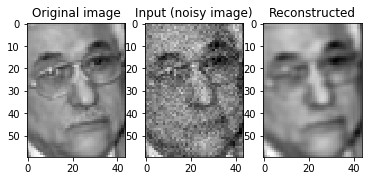

In [0]:
cont = 1
print(custos[cont])
plota_pra_mim_pfv(predicoes[cont], 1)

Text(0.5, 1.0, 'mean_absolute_error')

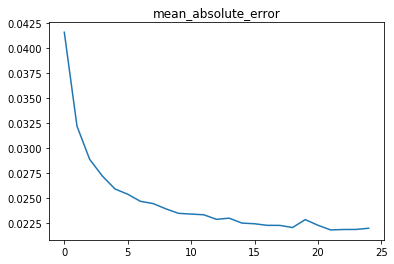

In [0]:
cont = 1

sns.lineplot(range(len(historias[cont].history['val_loss'])), historias[cont].history['val_loss']).set_title(custos[cont])

Text(0.5, 1.0, 'mean_absolute_error')

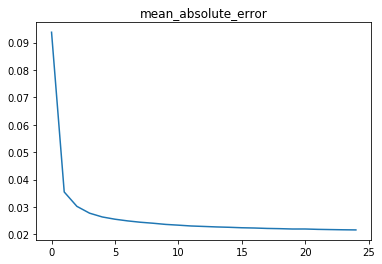

In [0]:
cont = 1

sns.lineplot(range(len(historias[cont].history['loss'])), historias[cont].history['loss']).set_title(custos[cont])

## Fim dos testes rápidos

## Fixando arquitetura, mudando funcao custo

## Compilando modelo

In [0]:
fatores1 = (1, 2, 4, 12, 20)
fatores2 = (1, 2, 4)
autoencoders = [None] * len(fatores1) * len(fatores2)
historias = [None] * len(fatores1) * len(fatores2)

cont = 0

for i in fatores1:
  for j in fatores2:
    def make_autoencoder():
      # encoding
      inputs = Input(shape=(60, 44, 1)) 
      x = Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same')(inputs) 
      x = MaxPooling2D(pool_size = (i, j), padding = 'same')(x)
      x = Conv2D(filters = 8, kernel_size = (3, 3), activation = 'relu', padding = 'same')(x) 
      encoded = MaxPooling2D(padding = 'same')(x)
      
      # decoding
      x = UpSampling2D(size = (i, j))(x)
      decoded = Conv2D(filters = 1, kernel_size = (3, 3), activation = 'sigmoid', padding = 'same')(x) 
      
      # autoencoder compilation
      autoencoder = Model(inputs, decoded)
      autoencoder.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics = metricas)
      return autoencoder
    autoencoders[cont] = make_autoencoder()
    historias[cont] = History()
    cont += 1

TypeError: 'int' object is not iterable

### Fittando

In [0]:
cont = 0
for i in fatores1:
  for j in fatores2:
    autoencoders[cont].fit(newfaces, faces, epochs=25, batch_size=128, callbacks=[historias[cont]], validation_split = 0.1)
    cont += 1

Train on 11909 samples, validate on 1324 samples
Epoch 1/25
11909/11909 [==============================] - 22s 2ms/step - loss: 0.6249 - mean_squared_error: 7.1518e-04 - mean_absolute_error: 0.0207 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 870.6744 - mean_squared_logarithmic_error: 3.2650e-04 - kullback_leibler_divergence: 8.8173e-04 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 0.6237 - val_mean_squared_error: 7.0652e-04 - val_mean_absolute_error: 0.0205 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 467.9577 - val_mean_squared_logarithmic_error: 3.2122e-04 - val_kullback_leibler_divergence: 0.0018 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 2/25
11909/11909 [==============================] - 24s 2ms/step - loss: 0.6249 - mean_squared_error: 7.1425e-04 - mean_absolute_error: 0.0207 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 874.8143 - mean_squared_logarithmic_error: 3.2628e-04 - kullba

Epoch 13/25
11909/11909 [==============================] - 35s 3ms/step - loss: 0.6248 - mean_squared_error: 6.7350e-04 - mean_absolute_error: 0.0201 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 873.1124 - mean_squared_logarithmic_error: 3.1146e-04 - kullback_leibler_divergence: 8.6880e-04 - accuracy: 5.6902e-05 - binary_accuracy: 5.6902e-05 - val_loss: 0.6235 - val_mean_squared_error: 6.6670e-04 - val_mean_absolute_error: 0.0200 - val_cosine_proximity: 1.0000 - val_mean_absolute_percentage_error: 480.8409 - val_mean_squared_logarithmic_error: 3.0723e-04 - val_kullback_leibler_divergence: 0.0011 - val_accuracy: 5.0066e-05 - val_binary_accuracy: 5.0066e-05
Epoch 14/25
11909/11909 [==============================] - 37s 3ms/step - loss: 0.6248 - mean_squared_error: 6.6998e-04 - mean_absolute_error: 0.0200 - cosine_proximity: 1.0000 - mean_absolute_percentage_error: 865.2783 - mean_squared_logarithmic_error: 3.1014e-04 - kullback_leibler_divergence: 8.4154e-04 - accuracy: 5

### Predizendo

In [0]:
predicoes = [None] * len(fatores1) * len(fatores2)
cont = 0

for i in fatores1:
  for j in fatores2:
    predicoes[cont] = autoencoders[cont].predict(faces)
    cont += 1

In [0]:
cont = 0
fator = [None] * len(fatores1) * len(fatores2)


for i in fatores1:
  for j in fatores2:
    fator[cont] = (i, j)
    cont += 1
    

### Resultados

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 60, 44, 16)        0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 60, 44, 8)         1160      
_________________________________________________________________
up_sampling2d_51 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

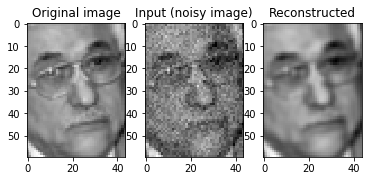

In [0]:
plota_pra_mim_pfv(predicoes[0], 1)
autoencoders[0].summary()

Model: "model_17"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_49 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_33 (MaxPooling (None, 60, 22, 16)        0         
_________________________________________________________________
conv2d_50 (Conv2D)           (None, 60, 22, 8)         1160      
_________________________________________________________________
up_sampling2d_17 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_51 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

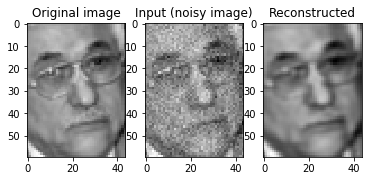

In [0]:
plota_pra_mim_pfv(predicoes[1], 1)
autoencoders[1].summary()

Model: "model_18"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_18 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_52 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_35 (MaxPooling (None, 60, 11, 16)        0         
_________________________________________________________________
conv2d_53 (Conv2D)           (None, 60, 11, 8)         1160      
_________________________________________________________________
up_sampling2d_18 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_54 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

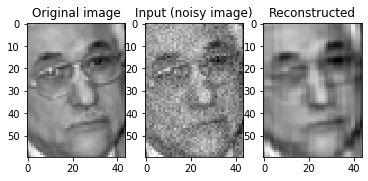

In [0]:
plota_pra_mim_pfv(predicoes[2], 1)
autoencoders[2].summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_19 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_37 (MaxPooling (None, 30, 44, 16)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 30, 44, 8)         1160      
_________________________________________________________________
up_sampling2d_19 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

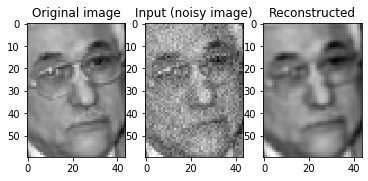

In [0]:
plota_pra_mim_pfv(predicoes[3], 1)
autoencoders[3].summary()

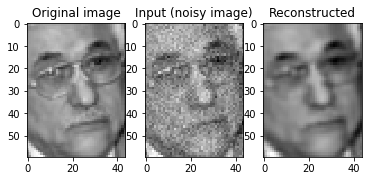

In [0]:
plota_pra_mim_pfv(predicoes[4], 1)

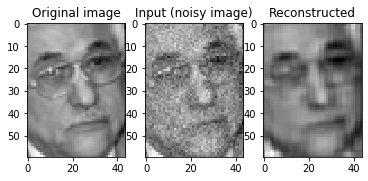

In [0]:
plota_pra_mim_pfv(predicoes[5], 1)

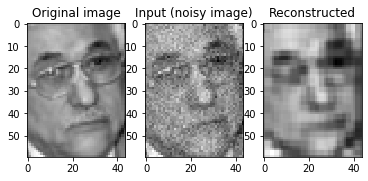

In [0]:
plota_pra_mim_pfv(predicoes[8], 1)

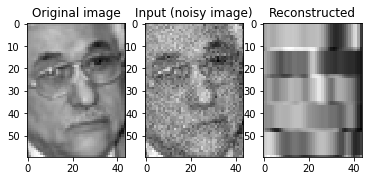

In [0]:
plota_pra_mim_pfv(predicoes[9], 1)

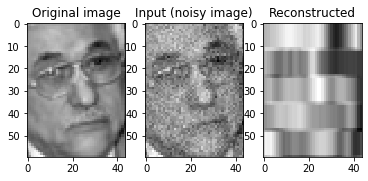

In [0]:
plota_pra_mim_pfv(predicoes[10], 1)

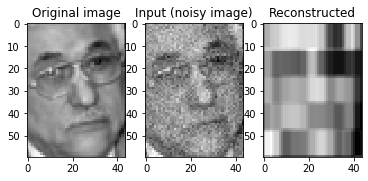

In [0]:
plota_pra_mim_pfv(predicoes[11], 1)

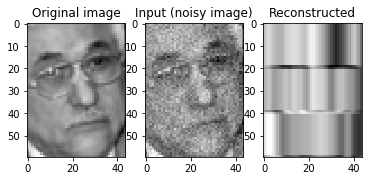

In [0]:
plota_pra_mim_pfv(predicoes[12], 1)

Model: "model_29"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_29 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_85 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_57 (MaxPooling (None, 3, 22, 16)         0         
_________________________________________________________________
conv2d_86 (Conv2D)           (None, 3, 22, 8)          1160      
_________________________________________________________________
up_sampling2d_29 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_87 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

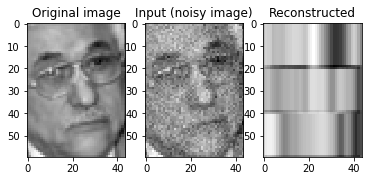

In [0]:
plota_pra_mim_pfv(predicoes[13], 1)
autoencoders[13].summary()

Model: "model_30"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_30 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_88 (Conv2D)           (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_59 (MaxPooling (None, 3, 11, 16)         0         
_________________________________________________________________
conv2d_89 (Conv2D)           (None, 3, 11, 8)          1160      
_________________________________________________________________
up_sampling2d_30 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_90 (Conv2D)           (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

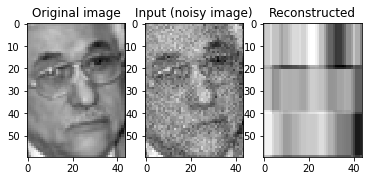

In [0]:
plota_pra_mim_pfv(predicoes[14], 1)
autoencoders[14].summary()

### Salvando objetos

In [0]:
for i in range(len(fatores1) * len(fatores2)):
    autoencoders[i].save("autoencoders%i" % i)

## Plotando métricas por epoch

In [0]:
# tem que botar callbacks=[history] no momento do fit.
print(historias[0].history)

{'loss': [0.6263171215271054, 0.6258155853806155, 0.6255061914615779, 0.6253106775516593, 0.6251631708747989, 0.625071120863012, 0.6250368366478919, 0.6249772686811654, 0.6249579852971235, 0.6249385578448762, 0.6249187965877002, 0.6248951692984036, 0.6248906732713574, 0.6248843239601044, 0.6248921008775954, 0.624872386716782, 0.624876657049735, 0.624875347882561, 0.6248483689591826, 0.6248637329448353, 0.624842973322246, 0.6248296267824325, 0.6248428272676695, 0.6248250089336359, 0.6248349360144797], 'mean_squared_error': [0.0012840093, 0.0010783204, 0.000956996, 0.0008853017, 0.00083182286, 0.0007993744, 0.00078973337, 0.00076748943, 0.0007623245, 0.00075565366, 0.0007487452, 0.0007399533, 0.00073887553, 0.0007372129, 0.0007414284, 0.00073327764, 0.0007358715, 0.00073564734, 0.00072404754, 0.0007314177, 0.0007227169, 0.0007172185, 0.00072346715, 0.0007160406, 0.0007210436], 'mean_absolute_error': [0.02523484, 0.023949984, 0.02304349, 0.02249761, 0.021969853, 0.021636236, 0.021579234, 

Text(0.5, 1.0, 'kullback_leibler_divergence')

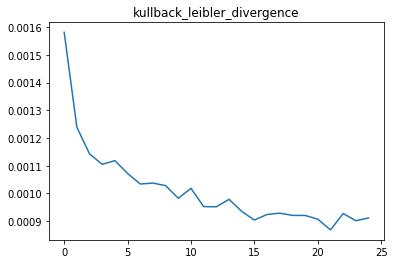

In [0]:
metrica = metricas[5]
cont = 0
sns.lineplot(range(len(historias[cont].history[metrica])), historias[cont].history[metrica]).set_title(metrica)

Text(0.5, 1.0, 'mean_squared_error')

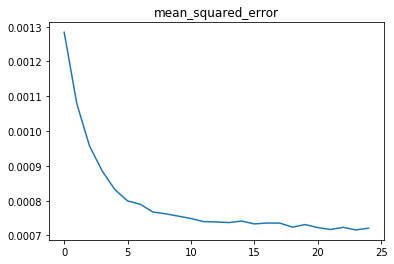

In [0]:
metrica = metricas[0]
cont = 0
sns.lineplot(range(len(historias[cont].history[metrica])), historias[cont].history[metrica]).set_title(metrica)

Text(0.5, 1.0, 'loss')

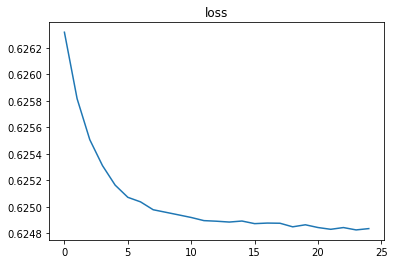

In [0]:
metrica = 'loss'
cont = 0
sns.lineplot(range(len(historias[cont].history[metrica])), historias[cont].history[metrica]).set_title(metrica)
# nesse caso loss é a binary cross entropy

### Para salvar o history vou ter que usar o pickle. O .save() do keras não salva o histórico

In [0]:
import pickle

In [0]:
pickle.dump(historias, open( "save_historias", "wb" ) )

## Carregando objetos em outra sessão

In [0]:
from keras.models import load_model
modelo = load_model('autoencoders0')

certas características tipo training history e variáveis de contexto que afetam mais a usabilidade não são salvas, só coisas tipo pesos da rede mesmo que são salvas.

por isso tive que usar o pickle pra salvar a lista das historias

In [0]:
historias = pickle.load( open( "save_historias", "rb" ) )

In [0]:
type(modelo)

keras.engine.training.Model

In [0]:
modelo

In [0]:
modelo.summary()

Model: "model_51"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_51 (InputLayer)        (None, 60, 44, 1)         0         
_________________________________________________________________
conv2d_151 (Conv2D)          (None, 60, 44, 16)        160       
_________________________________________________________________
max_pooling2d_101 (MaxPoolin (None, 60, 44, 16)        0         
_________________________________________________________________
conv2d_152 (Conv2D)          (None, 60, 44, 8)         1160      
_________________________________________________________________
up_sampling2d_51 (UpSampling (None, 60, 44, 8)         0         
_________________________________________________________________
conv2d_153 (Conv2D)          (None, 60, 44, 1)         73        
Total params: 1,393
Trainable params: 1,393
Non-trainable params: 0
________________________________________________________

Queria plotar os pesos como uma imagem, mas não to conseguindo entender esse objeto modelo.weights

In [0]:
np.array(modelo.weights[0])

array(<tf.Variable 'conv2d_151/kernel:0' shape=(3, 3, 1, 16) dtype=float32, numpy=
array([[[[ 0.05724442,  0.19854532, -0.08246384, -0.04647661,
          -0.01548494,  0.14917083, -0.24050637, -0.07443369,
          -0.0086793 ,  0.02763049,  0.1303676 ,  0.09324955,
           0.1768916 ,  0.05725028, -0.01016349, -0.00129684]],

        [[-0.09474679,  0.17755261, -0.08535835,  0.16020219,
           0.00260242,  0.12172101, -0.26698017, -0.12618814,
          -0.02596833, -0.08150528,  0.03549315, -0.05744288,
           0.17142555, -0.04370416,  0.15633373,  0.17304184]],

        [[-0.18500896, -0.03662722,  0.06418329, -0.03595619,
          -0.04237462, -0.01223998, -0.29903618, -0.07475214,
           0.11886081, -0.1482142 ,  0.15922378,  0.25540707,
          -0.07779668,  0.03951329,  0.12030627, -0.15612186]]],


       [[[ 0.20174679,  0.10179184,  0.26875004,  0.16397482,
          -0.01692513,  0.01361868,  0.0408058 ,  0.05424308,
          -0.06474304,  0.1983375 , -0

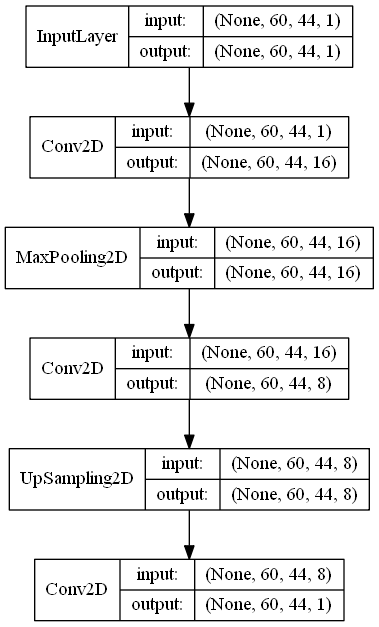

In [0]:
# jeito melhor de visualizar a arquitetura
plot_model(modelo, show_shapes=True, show_layer_names=False)

In [0]:
def plot_conv_weights(model, layer):
    W = model.get_layer(name=layer).get_weights()[0]
    if len(W.shape) == 4:
        W = np.squeeze(W)
        W = W.reshape((W.shape[0], W.shape[1], W.shape[2]*W.shape[3])) 
        fig, axs = plt.subplots(5,5, figsize=(8,8))
        fig.subplots_adjust(hspace = .5, wspace=.001)
        axs = axs.ravel()
        for i in range(25):
            axs[i].imshow(W[:,:,i])
            axs[i].set_title(str(i))

In [0]:
plot_conv_weights(modelo, 1)

TypeError: can only concatenate str (not "int") to str